


----------------------------------------------------------------------------------------------
****************************************** Modeling ******************************************

-------------------- This is Regression problem --------------------
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

 ------------------------------------- Linear Regression -------------------------------------


Starting Feature selection for Linear regression........
Droppped 0 useless features.


-------------------------

NOTE: This summary saved as <summary_OLS_1.csv>

-------------------------

                         Variable        coef    std err       t  P>|t|      [0.025      0.975] Indicator
0            3SsnPorch_str__"0.0"  36680.0000   8261.089   4.439  0.000   20500.000   52900.000       ***
1       3SsnPorch_str__Rare cases  52680.0000   9258.515   5.690  0.000   34500.000   70900.000       ***
2         BedroomAbvGr_str__"2.0"  -3582.8472   2623.239  -1.

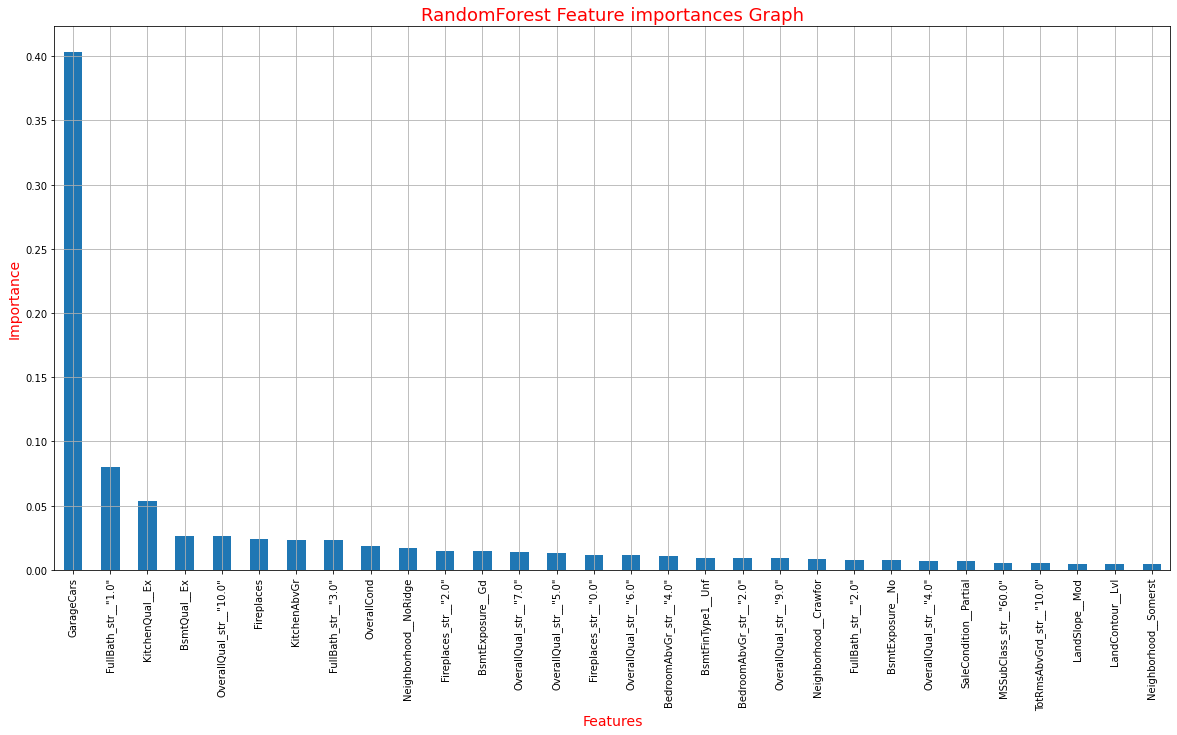


-------------------------

--- Model statistic ---
R^2 (test) : 0.8477451606139892
R^2 (train): 0.9715373506644983
RMSE (test): 31269
oob score  : 0.805959885711734

-------------------------

Maximum correlation between Reseduals and any data columns is 0.27576995656306935, with columns <Neighborhood__StoneBr>


In [1]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport
from dateutil import relativedelta
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn import metrics
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import pprint

warnings.filterwarnings("ignore")
plot_______ = False
summary__   = False
# modeling_   = False

# plot_______ = True
# summary__   = True
modeling_     = True


def add_new_date_cols(x, suffix):
    d = {}
    d[suffix + '_week_normalized'] = x.dt.week / 52
    d[suffix + '_week_str'] = '"' + x.dt.week.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_year_after_min_year'] = x.dt.year - x.dt.year.min()
    d[suffix + '_year_str'] = '"' + x.dt.year.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_day_name']  = x.dt.day_name()

    d[suffix + '_day_after_min_date_str']  = '"' + (x - x.min()).apply(lambda x: str(x).split()[0]) + '"'

    d[suffix + '_day_normalized'] = x.dt.day / 31

    d[suffix + '_hour_normalized'] = x.dt.hour / 24
    d[suffix + '_hour_str'] = '"' + x.dt.hour.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_month_name'] = x.dt.month_name()
    d[suffix + '_month_normalized'] = x.dt.month/12
    for k,v in d.items():
        if v.nunique() > 1:
            df[k] = v
    return df.drop(columns=x.name)
    # return

def new_line():
    print("\n-------------------------\n")

def RMSE(predictions):
    return round(np.sqrt(((test_y - predictions)**2).mean()))

def cluping_rare_cases_in_one_catagory(x):
    global df
    x = df[x]
    orignal  = x.copy("deep")
    xx = x.value_counts()
    xx = xx[xx< 10].index.to_list()
    x =  x.replace(xx , "Rare cases")
    if x.value_counts()[-1] < 8:
        x[x == "Rare cases"] = x.mode()[0] # agar "Rare cases" vali catogery me 8 sy bhi kam values hon to un ko most common value sy replace kar do
    if x.nunique() == 1:
        new_line()
        # to_print = f"The column <{x.name}> have only one unique value, We droped it from the data."
        to_print = f"The column <{x.name}> have imbalanced, so we droped it, it has {orignal.nunique()} unique values, and most commont value frequency ratio is {(orignal == orignal.mode()[0]).mean()}"
        print(colored(to_print, 'red'))
        # return orignal
        df.drop(columns=x.name, inplace=True)
        return None
    return x

def plot_numerical_columns(col_name):
    if not plot_______:
        return None

    # Histogram
    df[col_name].plot(kind="hist", figsize=(13,8));
    plt.title(col_name, size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    # Scatter plot
    df[col_name].plot(figsize=(13,8));
    plt.title(col_name, size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    # scatter plot (sort by values), values Vs index
    df[col_name].sort_values().reset_index(drop=True).plot(figsize=(13,8));
    plt.title(col_name+" (SORTED)", size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    # box plot
    df[col_name].plot(kind="box", figsize=(13,8))
    plt.title(col_name, size=18);
    plt.xlabel("");
    plt.show()

def plot_date_columns(col_name):
    if not plot_______:
        return None
    df[col_name].plot(figsize=(15,7), grid=True);
    plt.xlabel("Index", size=14);
    plt.ylabel("Date", size=14);
    plt.title(col_name + " Graph", size=18);
    plt.show();

    df[col_name].sort_values().reset_index(drop=True).plot(figsize=(15,7), grid=True);
    plt.xlabel("Index (sorted)", size=14);
    plt.ylabel("Year", size=14);
    plt.title(col_name + " Graph", size=18);
    plt.show();

    (df[col_name].dt.year.value_counts(sort=False).sort_index() / len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Year", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " year Frequency Graph", size=18);
    plt.show();

    (df[col_name].dt.month.value_counts().sort_index()/len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Month", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " month Frequency Graph", size=18);
    plt.show();

    (df[col_name].dt.day.value_counts().sort_index()/len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Day", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " Day Frequency Graph", size=18);
    plt.show();

def plot_catagorical_columns(cat_variable):
    if not plot_______:
        return None
    (df[cat_variable].value_counts() / len(df) * 100).plot.bar(figsize=(15,6), grid=True);
    plt.title(cat_variable, size=18, color='r');
    plt.xlabel("Catagory", size=14, color='r');
    plt.ylabel("Ratio (1-100)", size=14, color='r');
    plt.show()

def data_shape():
    return f"The Data have:\n\t{df.shape[0]} rows\n\t{df.shape[1]} columns\n"
# #===
# # df = pd.read_csv("data.csv", date_parser=True)
#
# # df = pd.read_csv("df_only_selected_columns_using_PCA.csv", date_parser=True)
# # target_variable = "ACTUAL_WORTH"
# # df = pd.concat([
# #         df.select_dtypes("number").iloc[:, :3],
# #         df.select_dtypes("O").iloc[:, :3],
# #         df.select_dtypes(exclude=["number", "O"]),
# #         df[[target_variable]]], 1)
# # target_variable = "AREA_NAME_EN"
#
# # df = pd.read_csv("cleaned_data.csv", date_parser=True)
# # target_variable = "SalePrice"
#
# train = pd.read_csv("/home/amir/Downloads/train.csv")
# test  = pd.read_csv("/home/amir/Downloads/test.csv")
target_variable = "SalePrice"
# train_y = train[target_variable]
# train = train.drop(columns=target_variable)
# df = pd.concat([train, test])
# df[target_variable] = train_y.to_list() + [None]*len(test)
# #===
# new_line()
# print(data_shape())
# #===
# new_line()
# print(f"Columns types distribution:\n\n{df.dtypes.value_counts()}\n")
# df.dtypes.value_counts().plot(kind='barh', figsize=(10, 2), grid=True, title="Variable types Count Graph");
# plt.xlabel("Count");
# plt.show()
# #===
# f = df[target_variable].isna().sum()
# if f:
#     new_line()
#     to_print = f"There are {f} NAs in target values, we droped those rows"
#     print(colored(to_print, 'red'))
#     df = df[df[target_variable].notna()]
# del f
# #---------------------------------------------------
# # df.select_dtypes("O").columns[:5]
# # D = df.select_dtypes(exclude="O")
# # D2 = df.select_dtypes("O").iloc[:,:5]
# # df = pd.concat([D, D2], 1)
#
# # profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# # profile.to_file("your_report.html")
# #---------------------------------------- NA
# a = df.isna().sum().where(lambda x:x>0).dropna()
# if a.size:
#     new_line()
#     to_print = f"There are {len(a)} (out of {df.shape[1]}, [{round(len(a)/df.shape[1]*100)}%]) columns that contains 1 or more NA."
#     print(colored(to_print, 'red'))
#
#     for i in a.index:
#         df[i+"_NA_indicator"] = df[i].isna().replace({True : "Missing", False : "Not missing"})
#     new_line()
#     to_print = f"{a.size} NA_indicator variables added to the data\n"
#     print(colored(to_print, 'red'))
#
#
#     print("========= NA Graphs =========\n")
#     msno.matrix(df);
#     plt.title("NA Graph");
#     plt.show()
#
#     new_line()
#     sns.heatmap(df.isnull(), cbar=False);
#     plt.title("NA Graph");
#     plt.show()
# #===
# a = a.sort_values()/len(df)*100
# if (a == 100).sum():
#     new_line()
#     df.drop(columns=a[a==100].index, inplace=True)
#     to_print = f"There are {(a == 100).sum()} columns that are all Missing values, so we droped those.\nNow {data_shape()}\n\nDropped columns names:"
#     print(colored(to_print, 'red'))
#     for i in a[a==100].index:
#         print("\t",i)
#     a = a[a != 100]
# #===
# x = df[a.index].dtypes.value_counts()
# if x.size:
#     new_line()
#     print(f"NA columns data type Distribution:\n\n{x}")
# del x
# #===
# new_line()
# if a.size:
#     print(f"NaN Ratio (0-100)\n\n{a}")
# else:
#     print(colored("Now There is no NaN value in our Data", 'red'))
# #===
# # ----------------------------------------------- Imputing Missing values
# # ------------------------------------ Numerical columns imputing
# if df.select_dtypes("number").isna().sum().sum():
#     new_line()
#     print(f'(Before Missing values treatment)\nThere are {df.isna().sum().sum()} Missing values:\n\t{df.select_dtypes("O").isna().sum().sum()} in catagorical variables\n\t{df.select_dtypes("number").isna().sum().sum()} in numerical columns\n\t{df.select_dtypes(exclude=["O", "number"]).isna().sum().sum()} in others')
#     from sklearn.impute import KNNImputer
#     df_not_a_number  = df.select_dtypes(exclude="number")
#     df_number        = df.select_dtypes("number")
#     del df
#     imputer = KNNImputer(n_neighbors=4, weights="uniform")
#     imputed = imputer.fit_transform(df_number)
#     df_number = pd.DataFrame(imputed, columns=df_number.columns)
#     df = pd.concat([df_not_a_number.reset_index(drop=True), df_number.reset_index(drop=True)], axis=1)
#     del df_not_a_number
#     del df_number
#     print(f'\n(After filling numeric missing values)\nThere are {df.isna().sum().sum()} Missing values:\n\t{df.select_dtypes("O").isna().sum().sum()} in catagorical variables\n\t{df.select_dtypes("number").isna().sum().sum()} in numerical columns\n\t{df.select_dtypes(exclude=["O", "number"]).isna().sum().sum()} in others')
# #===
# # -------------------------------- Catagoriacal variables imputating
# vars_to_fill = df.select_dtypes("O").isna().mean().where(lambda x:x>0).dropna().sort_values(ascending=True)
# if vars_to_fill.size:
#     for col in vars_to_fill.index:
#         tr = pd.concat([df[[col]], df.loc[:,df.isna().sum() == 0]], 1)
#         tr_y = tr[col]
#         tr_X = tr.drop(columns=col)
#
#         tr_T = tr_X.select_dtypes("number")
#         cat_cols = pd.get_dummies(tr_X.select_dtypes(exclude="number"), prefix_sep="__")
#         tr_T[cat_cols.columns.to_list()] = cat_cols
#
#         tr_T[col] = tr_y
#         tr = tr_T.copy("deep")
#
#         train = tr[tr[col].notna()]
#         test  = tr[tr[col].isna()]
#
#         train_y = train[col]
#         train_X = train.drop(columns=col)
#
#         test_X = test.drop(columns=col)
#
#         clf = DecisionTreeClassifier().fit(train_X, train_y)
#         test_y = clf.predict(test_X)
#
#         df.loc[df[col].isna(), col] = test_y
#     new_line()
#     print(f"Missing values imputed, Now there are {df.isna().sum().sum()} Missing values")
# # ----------------------------------------------- END Imputing Missing values
# # --------------------------------------------------------- Unique values
# only_one_unique_value = df.nunique().where(lambda x:x == 1).dropna()
# if only_one_unique_value.size:
#     new_line()
#     df.drop(columns=only_one_unique_value.index, inplace=True)
#     last_ = ("", "it") if  only_one_unique_value.size == 1 else ("s", "those")
#     to_print = f"There are {only_one_unique_value.size} variable{last_[0]} That have only one unique value, so we droped {last_[1]}.\nDropped column{last_[0]} name{last_[0]} (in order):"
#     print(colored(to_print, 'red'))
#     for i in only_one_unique_value.index.sort_values():
#         print(i)
#     new_line()
#     print(f"\nNow {data_shape()}")
# del only_one_unique_value
# # #===
# all_values_are_unique = df.apply(lambda x:x.is_unique).where(lambda x:x==True).dropna()
# if all_values_are_unique.size:
#     new_line()
#     df.drop(columns=all_values_are_unique.index, inplace=True)
#     last_ = ("", "it") if  all_values_are_unique.size == 1 else ("s", "those")
#     to_print = f"There are {all_values_are_unique.size} column{last_[0]} that have all unique values, so no value repeatation, we droped {last_[1]} column{last_[0]}.\nDropped column{last_[0]} name{last_[0]} are:\n"
#     print(colored(to_print, 'red'))
#     for i in all_values_are_unique.index:
#         print("\t", i)
#     new_line()
#     print(f"Now {data_shape()}")
# del all_values_are_unique
# #===
# date_columns = []
# def DTYPES():
#     global date_columns
#     catagorical_columns = df.head().select_dtypes("O").columns
#     numerical_columns   = df.head().select_dtypes("number").columns
#     date_columns        = []
#
#     for i in catagorical_columns:
#         try:
#             df[i] = pd.to_datetime(df[i])
#             date_columns.append(i)
#         except:
#             pass
#
#     catagorical_columns = catagorical_columns.drop(date_columns)
#     if date_columns:
#         date_columns = pd.Index(date_columns)
#     #===
#     if not catagorical_columns.append(numerical_columns).append(date_columns).is_unique:
#         new_line()
#         print(colored("Some column/s repated in > 1 dtypes\n", 'red'))
#         dtypes = pd.DataFrame({"Column" : catagorical_columns.append(numerical_columns).append(date_columns),
#                     "dtype" : ['O']*len(catagorical_columns) + ['Number']*len(numerical_columns) + ['Date']*len(date_columns)})
#         print(dtypes[dtypes.Column.isin(list(dtypes[dtypes.Column.duplicated()].Column.values))].to_string())
#     #===
#     x = df.columns.difference(
#         catagorical_columns.append(numerical_columns).append(date_columns)
#         )
#     if x.size:
#         new_line()
#         print(colored("Some columns not included in any existing catagory, those:\n", 'red'))
#         for i in x:
#             print(f"\t<{i}, with dtype of <{df[i].dtype}>")
#     #===
#     dtypes = pd.DataFrame({"Column" : catagorical_columns.append(numerical_columns).append(date_columns),
#                 "dtype" : ['Object']*len(catagorical_columns) + ['Number']*len(numerical_columns) + ['Date']*len(date_columns)})
#     return dtypes
# #===
# dtypes = DTYPES()
# # ----------------------------------------------------------------------- Feature enginearing
# # ======= Adding date columns
# # ?????????????????????????? add polynomial, sqrt, tree, log features
# len_df_before_adding_date_vars = df.shape[1]
# for date_col in date_columns:
#     df = add_new_date_cols(df[date_col], date_col)
# len_df_after_adding_date_vars  = df.shape[1]
# if len_df_after_adding_date_vars > len_df_before_adding_date_vars:
#     new_line()
#     to_print = f"Added {len_df_after_adding_date_vars - len_df_before_adding_date_vars} date Features"
#     print(colored(to_print, 'red'))
#
# # ======= type casting of numerical variable (those who have < 4% unique values) to catagorical variables
# f = (df.select_dtypes("number").nunique() / len(df) * 100).where(lambda x:x<4).dropna().index
# if f.size:
#     len_df_before_adding_date_vars = df.shape[1]
#     for col_num_to_str in f:
#         df[col_num_to_str+"_str"] = '"' + df[col_num_to_str].astype(str) + '"'
#     len_df_after_adding_date_vars  = df.shape[1]
#     new_line()
#     to_print = f"Added {len_df_after_adding_date_vars - len_df_before_adding_date_vars} String Features (Extracted from numerical variables)"
#     print(colored(to_print, 'red'))
# # =======
# for var in df.select_dtypes("O").columns:
#     m = cluping_rare_cases_in_one_catagory(var)
#     if isinstance(m, pd.core.series.Series):
#         df[var] = m
# new_line()
#
# xx = (df == 'Rare cases').sum().sort_values().where(lambda x:x>0).dropna()
# xx = pd.DataFrame({"Count" : xx,
#                 "Ratio" : round(xx/len(df)*100, 4)})
# print(f"<Rare case> catagory:\n{xx.to_string()}")
# # ----------------------------------------------------------------------- END (Feature enginearing)
# dtypes = DTYPES()
# # ---------------------------------------------------- Correlation plot
# new_line()
# cor_df = df.select_dtypes('number').corr().abs()
# mask = np.triu(np.ones_like(cor_df, dtype=bool));
# f, ax = plt.subplots(figsize=(17, 10));
# cmap = sns.color_palette("viridis", as_cmap=True);
# plot_ = sns.heatmap(cor_df, mask=mask, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5});
# plot_.axes.set_title("abs (Correlation) plot",fontsize=25);
# plt.show()
# # ---------------------------------------------------------------------
# #===
# # m = 0
# if summary__:
#     for row in dtypes.iterrows():
#         # m += 1
#         # if m == 3:
#             # break
#         column_name, type_ = row[1]
#         x = df[column_name]
#         to_print = f"\n\n\n========================================= {column_name} =========================================\n\n"
#         print(colored(to_print, 'red'))
#
#         for col_ in df.columns:
#             if col_ == column_name:
#                 continue
#             if df[col_].nunique() == df[column_name].nunique():
#                 unique_combination = df[[col_, column_name]].drop_duplicates()
#                 if unique_combination.apply(lambda x:x.is_unique).sum() == 2:
#                     new_line()
#                     to_print = f"This Columns is duplicate of <{col_}> column"
#                     print(colored(to_print, 'red'))
#
#         # print(f"Column Type     : {type_}")
#         print(f"Column Type     : ", end="")
#         print(colored(type_, 'red'))
#         if x.isna().all():
#             new_line()
#             df.drop(columns=column_name, inplace=True)
#             print(colored("We dropped This column, because it is all Empty", 'red'))
#             continue
#         if type_ in ["O", "Date"]:
#             if x.is_unique:
#                 new_line()
#                 df.drop(columns=column_name, inplace=True)
#                 to_print = f"We dropped This column, because it's a {type_} columns, and it's all values are unique"
#                 print(colored(to_print, 'red'))
#                 continue
#         if x.nunique() == 1:
#             new_line()
#             df.drop(columns=column_name, inplace=True)
#             print(colored("We dropped This column, because There is only one unique value", 'red'))
#             continue
#
#         if type_ == "Number":
#             local_cor = cor_df[column_name].drop(column_name).reset_index()
#             local_cor = local_cor.reindex(local_cor[column_name].abs().sort_values().index)
#             if local_cor[column_name].max() == 1:
#                 new_line()
#                 to_print = f"This column is perfactly correlated with column <{local_cor[local_cor[column_name] == 1]['index'].values[0]}, so remove one of them"
#                 print(colored(to_print, 'red'))
#
#             new_line()
#             xm = local_cor[-3:].rename(columns={'index' : 'Column name', column_name : 'Correlation'}).reset_index(drop=True)
#             xm.index = xm['Column name']
#             xm.drop(columns="Column name", inplace=True);
#             xm.plot(kind='barh', grid=True, figsize=(10,1.5));
#             plt.title("Most 3 correlated features with this columns (sorted)", size=14);
#             plt.xlabel("Correlation", size=12);
#             plt.show();
#
#             new_line()
#             skewness = x.skew(skipna = True)
#             if abs(skewness) < 0.5:
#                 print(f"The data is fairly symmetrical (skewness is: {skewness})")
#             elif abs(skewness) < 1:
#                 print(f"The data are moderately skewed (skewness is: {skewness})")
#             else:
#                 to_print = f"The data are highly skewed (skewness is: {skewness})\nNote: When skewness exceed |1| we called it highly skewed"
#                 print(colored(to_print, 'red'))
#
#             # f = x.describe()
#             # f['Nunique'] = x.nunique()
#             # f['Nunique ratio'] = f.loc["Nunique"] / f.loc["count"] * 100
#             # f['Outlies count'] = (((x - x.mean())/x.std()).abs() > 3).sum()
#             # f['Outlies ratio'] = f.loc["Outlies count"] / f.loc["count"] * 100
#             # f['Nagative values count'] = (x < 0).sum()
#             # f['Nagative values ratio'] = f['Nagative values count'] / f['count'] * 100
#
#             ff = [x.count(), x.isna().sum(), x.mean(), x.std(), x.min()]
#             ff += x.quantile([.25,.5,.75]).to_list()
#             ff += [x.max(), x.nunique(), (((x - x.mean())/x.std()).abs() > 3).sum(), (x < 0).sum(), (x == 0).sum()]
#
#             f = pd.DataFrame(ff, index=['Count', 'NA', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Nunique', 'Outlies', 'Nagetive', 'Zeros'], columns=['Count'])
#             f['Ratio'] = f.Count / x.count() * 100
#             f.loc['Mean' : 'Max', 'Ratio'] = None
#
#             new_line()
#             print(f.round(2).to_string())
#             plot_numerical_columns(column_name)
#
#         elif type_ == "Object":
#             # f = x.describe()
#             # f = x.agg(['count', pd.Series.nunique])
#             # f['len'] = len(x)
#             # f['Na count'] = x.isna().sum()
#             # f['Na ratio'] = f['Na count'] / f['count'] * 100
#             # f['Most frequent'] = x.mode().values[0]
#             # f['Most frequent count'] = (x == f['Most frequent']).sum()
#             # f['Most frequent ratio'] = f['Most frequent count'] / f['count'] * 100
#             # f['Least frequent'] = x.value_counts().tail(1).index[0]
#             # f['Least frequent count'] = (x == f['Least frequent']).sum()
#             # f['Least frequent ratio'] = f['Least frequent count'] / f['count'] * 100
#             # f['Values occured only once count'] = x.value_counts().where(lambda x:x==1).dropna().size
#             # f['Values occured only once Ratio'] = f['Values occured only once count'] / x.count() * 100
#
#             l = x.count(), x.nunique(), len(x), x.isna().sum(), (x == x.mode().values[0]).sum(), (x == x.value_counts().tail(1).index[0]).sum(), x.value_counts().where(lambda x:x==1).dropna().size
#             f = pd.DataFrame(l, index=['Count', 'Nunique', 'Len', 'NA', 'Most frequent', 'Least frequent', 'Values occured only once'], columns=['Counts'])
#             f['Ratio'] = (f.Counts / x.count() * 100).round(4)
#             f.loc[['Len'], 'Ratio'] = None
#
#             new_line()
#             print(f.to_string())
#
#
#             if x.str.lower().nunique() != x.nunique():
#                 new_line()
#                 to_print = f"Case issue\n\tin orignal variable There are {x.nunique()} unique values\n\tin lower verstion there are   {x.str.lower().nunique()} unique values.\n"
#                 print(colored(to_print, 'red'))
#
#             if x.str.strip().nunique() != x.nunique():
#                 new_line()
#                 to_print = f"Space issue\n\tin orignal variable There are {x.nunique()} unique values\n\tin striped verstion there are {x.str.strip().nunique()} unique values."
#                 print(colored(to_print, 'red'))
#
#             plot_catagorical_columns(column_name)
#
#         elif type == "Date":
#
#             new_line()
#             rd = relativedelta.relativedelta( pd.to_datetime(x.max()), pd.to_datetime(x.min()))
#             to_print = f"Diffrenece between first and last date:\n\tYears : {rd.years}\n\tMonths: {rd.months}\n\tDays  : {rd.days}"
#             print(colored(to_print, 'red'))
#
#             # f = pd.Series({'Count' : x.count(),
#             #             'Nunique count' : x.nunique(),
#             #             'Nunique ratio' : x.nunique() / x.count() * 100,
#             #             'Most frequent value' : str(x.mode()[0]),
#             #             'Least frequent value' :  x.value_counts().tail(1).index[0]
#             #             })
#             # f['Most frequent count'] = (x == f['Most frequent value']).sum()
#             # f['Most frequent ratio'] = f['Most frequent count'] / f['Count'] * 100
#             # f['Least frequent count'] = (x == f['Least frequent value']).sum()
#             # f['Least frequent ratio'] = f['Least frequent count'] / f['Count'] * 100
#             # f['Values occured only once count'] = x.value_counts().where(lambda x:x==1).dropna().size
#             # f['Values occured only once Ratio'] = f['Values occured only once count'] / x.count() * 100
#
#             ff = x.count(), x.nunique(), (x == x.mode().values[0]).sum(), (x == x.value_counts().tail(1).index[0]).sum(), x.value_counts().where(lambda x:x==1).dropna().size
#             f = pd.DataFrame(ff, index=["Count", 'Nunique', 'Most frequent values', 'Least frequent values', 'Values occured only once count'], columns=['Counts'])
#             f['Ratio'] = (f.Counts / x.count() * 100).round(4)
#
#             new_line()
#             print(f"\n{f.to_string()}")
#
#
#             f = set(np.arange(x.dt.year.min(),x.dt.year.max()+1)).difference(
#                 x.dt.year.unique())
#             if f:
#                 new_line()
#                 print(colored("These Years (in order) are missing:\n", 'red'))
#                 for i in f:
#                     print("\t", i, end=", ")
#
#             f = set(np.arange(x.dt.month.min(),x.dt.month.max()+1)).difference(
#                 x.dt.month.unique())
#             if f:
#                 new_line()
#                 print(colored("These Months (in order) are missing:\n", 'red'))
#                 for i in f:
#                     print("\t", i, end=", ")
#
#             f = set(np.arange(x.dt.day.min(),x.dt.day.max()+1)).difference(
#                 x.dt.day.unique())
#             if f:
#                 new_line()
#                 print(colored("These Days (in order) are missing:\n", 'red'))
#                 for i in f:
#                     print("\t", i, end=", ")
#
#             new_line()
#             plot_date_columns(column_name)
#

# ================================================================================================================ Modeling
if modeling_:
    # pickle.dump(df, open("df.pkl", "wb"))
    df = pickle.load(open("df.pkl", "rb"))
    print("\n\n")
    to_print = "----------------------------------------------------------------------------------------------\n****************************************** Modeling ******************************************"
    print(colored(to_print, 'red'))

    # Regression problem
    if df[target_variable].dtype in [float, int]:

        to_print = "\n-------------------- This is Regression problem --------------------\n''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''"
        print(colored(to_print, 'red'))

        df_T = df.select_dtypes("number")
        cat_cols = pd.get_dummies(df.select_dtypes(exclude="number"), prefix_sep="__")
        df_T[cat_cols.columns.to_list()] = cat_cols

        df = df_T.copy("deep")
        del df_T
        del cat_cols
        # ====
        train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=target_variable), df[target_variable])
        # ====
        # --------------------------------------------------------- Linear regression
        to_print = "\n ------------------------------------- Linear Regression -------------------------------------\n"
        print(colored(to_print, 'red'))

        print("\nStarting Feature selection for Linear regression........")
        selector = SelectFromModel(estimator=LinearRegression()).fit(train_X, train_y).get_support(True)
        print(f"Droppped {(selector == False).sum()} useless features.\n")

        train_X = train_X.iloc[:, selector]
        test_X  = test_X.iloc [:, selector]

        model_reg = OLS(train_y, train_X).fit()
        summary = model_reg.summary()
        summary_df = pd.DataFrame(summary.tables[1])
        summary_df.columns = summary_df.iloc[0]
        summary_df.drop(0, inplace=True)
        summary_df.columns = summary_df.columns.astype(str)
        summary_df.columns = ["Variable"] + summary_df.columns[1:].to_list()
        for i in summary_df.columns[1:]:
            summary_df[i] = summary_df[i].astype(str).astype(float)
        summary_df.Variable = summary_df.Variable.astype(str)
        summary_df['Indicator'] = summary_df['P>|t|'].apply(lambda x:"***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "." if x < 0.1  else "")
        summary_df = summary_df.sort_values("Variable").reset_index(drop=True)
        summary_df.to_csv()
        new_line()
        print(colored("NOTE: This summary saved as <summary_OLS_1.csv>", 'red'))

        new_line()
        print(summary_df.to_string())
        # ============================= Model statistic
        predictions = model_reg.predict(test_X)

        new_line()
        print(colored(" --- Model statistic --- \n", 'red'))
        print(f"R-squared         : {round(model_reg.rsquared, 3)}")
        print(f"Adj. R-squared    : {round(model_reg.rsquared_adj, 3)}")
        print(f"F-statistic       : {round(model_reg.fvalue)}")
        print(f"Prob (F-statistic): {model_reg.f_pvalue}")
        print(f"No. Observations  : {round(model_reg.nobs)}")
        print(f"AIC               : {round(model_reg.aic)}")
        print(f"Df Residuals      : {round(model_reg.df_resid)}")
        print(f"BIC               : {round(model_reg.bic)}")
        print(f"RMSE (test)       : {RMSE(predictions)}")
        # ======
        f = train_X.copy("deep")
        f['Errors__'] = model_reg.resid
        f = f.corr()['Errors__'].drop("Errors__").abs().sort_values().dropna().tail(1)
        new_line()
        print(f"Maximum correlation between Reseduals and any data columns is {f.values[0]}, with columns <{f.index[0]}>")
        print(f"Mean of train reseduals: {model_reg.resid.mean()}")
        del f
        # ============================= END (Model statistic)
        # --------------------------------------------------------- END Linear regression




        # --------------------------------------------------------- Random Forest
        print("\n ------------------------------------- Random Forest -------------------------------------\n")

        rf = RandomForestRegressor(n_estimators = 200, oob_score=True)
        model_rf = rf.fit(train_X, train_y);
        predictions_rf = rf.predict(test_X)

        new_line()
        print(colored("RF model peramters:\n", 'red'))
        pprint.pprint(model_rf.get_params())

        new_line()
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(test_X, importances)]
        featuresImportance = pd.Series(model_rf.feature_importances_, index=train_X.columns).sort_values(ascending=False)
        if len(featuresImportance) > 30:
            featuresImportance = featuresImportance.head(30)
        featuresImportance.plot(figsize=(20,10), kind='bar', grid=True);
        plt.title("RandomForest Feature importances Graph", size=18,color='red');
        plt.xlabel("Features", size=14, color='red');
        plt.ylabel("Importance", size=14, color='red');
        plt.show();
        del featuresImportance

        new_line()
        print(colored("--- Model statistic ---", 'red'))
        # The coefficient of determination R^2 of the prediction.
        # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
        print(f"R^2 (test) : {rf.score(test_X, test_y)}")
        print(f"R^2 (train): {rf.score(train_X, train_y)}")
        print(f"RMSE (test): {RMSE(predictions_rf)}")
        print(f"oob score  : {model_rf.oob_score_}")

        f = test_X.copy("deep")
        errors_rf = predictions_rf - test_y
        f['Errors__'] = errors_rf
        f = f.corr()['Errors__'].drop("Errors__").abs().sort_values().dropna().tail(1)
        new_line()
        print(f"Maximum correlation between Reseduals and any data columns is {f.values[0]}, with columns <{f.index[0]}>")
        # --------------------------------------------------------- END Random Forest
    elif df[target_variable].dtype == "O":
        # Classififcation problem
        if df[target_variable].nunique() == 2:
            print("\n-------------------- This is Binary Classification problem --------------------\n")
            print("''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''")
            df = pd.concat([
                            df.select_dtypes(exclude = "O"),
                            pd.get_dummies(df.drop(columns=target_variable).select_dtypes("O")),
                            df[[target_variable]]
                            ], 1)

            train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=target_variable), df[target_variable])
            clf = LogisticRegression().fit(train_X, train_y)
            predictions = clf.predict_proba(test_X)
            predictions = pd.Series(predictions[:, 0])
            lst = []
            for thresh in np.linspace(predictions.min(), predictions.max(), 50)[1:]:
                pred = predictions < thresh

                pred.loc[pred == True] = clf.classes_[0]
                pred.loc[pred == False] = clf.classes_[1]

                test_y = test_y.reset_index(drop=True)

                TN = ((pred == clf.classes_[0]) & (test_y == clf.classes_[0])).sum()
                TP = ((pred == clf.classes_[1]) & (test_y == clf.classes_[1])).sum()
                FN = ((pred == clf.classes_[0]) & (test_y == clf.classes_[1])).sum()
                FP = ((pred == clf.classes_[1]) & (test_y == clf.classes_[0])).sum()

                p = TP / (TP + FP)
                r = TP / (TP + FN)
                f = 2 * ((p * r) / (p+r))

                lst.append((thresh, (pred == test_y).mean(), p, r , f))

            d = pd.DataFrame(lst, columns=["Thresold", "Accurecy(0-1)", "Precision", "Recall", "F1"])
            d = d.set_index("Thresold")
            d.plot(grid=True, figsize=(18,7));
            plt.title("Model performance at diffrent Thresolds", size=18, color='red');
            plt.xlabel("Thresold", size=14, color='red');
            plt.ylabel("");
            plt.show()
        else:
            to_print = "\n-------------------- This is Multiclass Classification problem --------------------\n"
            print(colored(to_print, 'red'))
            print("'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''")

            df.loc[:, df.select_dtypes("O").columns] = df.select_dtypes("O").apply(lambda x: pd.Series(LabelEncoder().fit_transform(x.astype(str))).astype(str))
            train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=target_variable), df[target_variable])

            clf=RandomForestClassifier(n_estimators=1000).fit(train_X, train_y)
            predictions = clf.predict(test_X)
            feature_imp = pd.Series(clf.feature_importances_,index=train_X.columns).sort_values(ascending=False)
            if feature_imp.size > 30:
                feature_imp = feature_imp.head(30)
            feature_imp.plot(kind='barh', figsize=(17,10), grid=True);
            plt.title("Feature importances Graph", size=18, color='red');
            plt.xlabel("Importance", size=14, color='red');
            plt.ylabel("Feature", size=14, color='red');
            plt.show()
            # ====
            f = (test_y, predictions)
            f_int = (test_y.astype(int), predictions.astype(int))

            print(f"accuracy_score: {metrics.accuracy_score(*f)}")
            print(f"f1_score: {metrics.f1_score(*f_int)}")

            metrics.plot_roc_curve(clf, test_X, test_y);
            plt.title("ROC curve plot");
            plt.show();

            metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(*f)); plt.show()

            metrics.plot_confusion_matrix(clf, test_X, test_y);
            plt.title("Confusion matrix");
            plt.show()

            metrics.plot_precision_recall_curve(clf, test_X, test_y);
            plt.title("Precision recall curve");
            plt.show()
    # ================================================================================================================ END Modeling

# sklearn.feature_selection
# <SelectKBest>             removes all but the highest scoring features
#     from sklearn.feature_selection import SelectKBest
#     from sklearn.feature_selection import chi2
#     X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
# <SelectPercentile>        removes all but a user-specified highest scoring percentage of features
# <GenericUnivariateSelect> allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.
